In [49]:
# -*- coding: utf-8 -*-
"""withlocation.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1T0QirBObO6kAO1YSBV7PHyYzfnUUB7-K
"""

import pandas as pd
from sklearn.model_selection import train_test_split
import re
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import string
import re
import spacy
import contextualSpellCheck
from sklearn.pipeline import Pipeline
import matplotlib


In [50]:
# !python -m spacy download en_core_web_lg


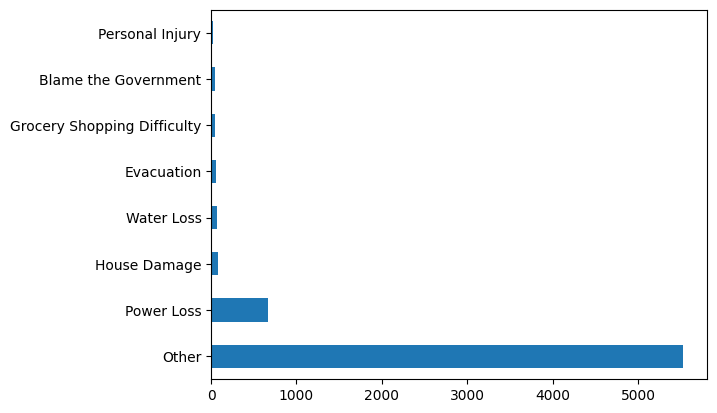

In [56]:
def  prune_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    return df

data = pd.read_csv("data.csv")
location = pd.read_csv("louisiana_city.csv")
data.rename(columns={'New Classification':'label'},inplace=True)
data['cordinates'] = data['geo'].str[:-6]
required_columns = ['cordinates','tweet','label']
required_data = data[required_columns]
required_data = required_data[required_data.label != 'New Classification']
required_data.label.value_counts().plot(kind='barh')
le = preprocessing.LabelEncoder()
required_data['label'] = le.fit_transform(required_data['label'])
required_data[['x_cor','y_cor']] = required_data.cordinates.str.split(",",expand=True)
required_data = prune_text(required_data,'tweet')
required_data.drop(columns=['cordinates'],inplace=True)
required_data['x_cor'] = required_data['x_cor'].str.strip()
required_data['y_cor'] = required_data['y_cor'].str.strip()
location['Latitude'] = location['Latitude'].astype(str).str.strip()
location['Longitude'] = location['Longitude'].astype(str).str.strip()
location_data = pd.merge(required_data, location,  how='left', left_on=['x_cor','y_cor'], right_on = ['Latitude','Longitude'])
final_data = location_data[['tweet','Location','label']]

In [52]:
le.classes_

array(['Blame the Government', 'Evacuation',
       'Grocery Shopping Difficulty', 'House Damage',
       'New Classification', 'Other', 'Personal Injury', 'Power Loss',
       'Water Loss', nan], dtype=object)

In [9]:
class spe:
  def __init__(self):
    self.nlp = spacy.load('en_core_web_lg')
    self.nlp.add_pipe("contextual spellchecker", config={"max_edit_dist": 5})    
    self.punctuations = string.punctuation
    self.stopwords = spacy.lang.en.stop_words.STOP_WORDS

  def remove_urls(self,text):
      text = re.sub(r"\S*https?:\S*", "", text, flags=re.MULTILINE)
      return text

  def spacy_tokenizer(self,sentence):
      docs = self.nlp(sentence)

      # Lemmatize each token and convert each token into lowercase
      tokens = [word.lemma_.lower().strip() for word in docs]
      
      # Remove stopwords
      tokens = [word for word in tokens if word not in self.stopwords and word not in self.punctuations]
      
      # Remove links
      tokens = [self.remove_urls(word) for word in tokens]
      
      # return preprocessed list of tokens
      return tokens
tokenizer = spe()


Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29.0/29.0 [00:00<00:00, 6.78kB/s]
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 570/570 [00:00<00:00, 212kB/s]
Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 213k/213k [00:00<00:00, 1.27MB/s]
Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 436k/436k [00:00<00:00, 1.91MB/s]
Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 436M/436M [00:08<00:00, 51.7MB/s]


In [74]:
X_train, X_test, y_train, y_test = train_test_split(final_data[['tweet','Location']],final_data['label'],test_size=0.1, random_state = 0,stratify=final_data['label'])

In [75]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn import set_config


In [76]:
column_trans = ColumnTransformer([('Location', OneHotEncoder(dtype='int'), ['Location']),('tweet', TfidfVectorizer(), 'tweet')],remainder='drop', verbose_feature_names_out=False)

In [77]:
nb = MultinomialNB()
univariate_nb_pipe1 = Pipeline([('column_trans', column_trans), ('nb', nb)])
univariate_nb_pipe1.fit(X_train, y_train)
y_preds_uni_nb = univariate_nb_pipe1.predict(X_test)

In [78]:
set_config(display="diagram")
univariate_nb_pipe1 

Pipeline(steps=[('column_trans',
                 ColumnTransformer(transformers=[('Location',
                                                  OneHotEncoder(dtype='int'),
                                                  ['Location']),
                                                 ('tweet', TfidfVectorizer(),
                                                  'tweet')],
                                   verbose_feature_names_out=False)),
                ('nb', MultinomialNB())])

In [79]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

classes = [x for x in list(le.classes_) if str(x) != 'nan']
classes.append("unrecognised")
classes

['Blame the Government',
 'Evacuation',
 'Grocery Shopping Difficulty',
 'House Damage',
 'Other',
 'Personal Injury',
 'Power Loss',
 'Water Loss',
 'unrecognised']

In [80]:
print("Model Name: Naive Bayes")
print("Accuracy: "+ str(accuracy_score(y_test, y_preds_uni_nb)*100))
print(classification_report(y_test,y_preds_uni_nb, target_names=classes))


Model Name: Naive Bayes
Accuracy: 84.70948012232415
                             precision    recall  f1-score   support

       Blame the Government       0.00      0.00      0.00         4
                 Evacuation       0.00      0.00      0.00         6
Grocery Shopping Difficulty       0.00      0.00      0.00         5
               House Damage       0.00      0.00      0.00         8
                      Other       0.85      1.00      0.92       554
            Personal Injury       0.00      0.00      0.00         2
                 Power Loss       0.00      0.00      0.00        67
                 Water Loss       0.00      0.00      0.00         7
               unrecognised       0.00      0.00      0.00         1

                   accuracy                           0.85       654
                  macro avg       0.09      0.11      0.10       654
               weighted avg       0.72      0.85      0.78       654



In [81]:
from sklearn.tree import DecisionTreeClassifier

In [91]:
dt = DecisionTreeClassifier(random_state=0, max_depth=10)
univariate_dt_pipe = Pipeline([('column_trans', column_trans), ('dt', dt)])
univariate_dt_pipe.fit(X_train, y_train)
y_preds_univariate_dt = univariate_dt_pipe.predict(X_test)

In [92]:
univariate_dt_pipe

Pipeline(steps=[('column_trans',
                 ColumnTransformer(transformers=[('Location',
                                                  OneHotEncoder(dtype='int'),
                                                  ['Location']),
                                                 ('tweet', TfidfVectorizer(),
                                                  'tweet')],
                                   verbose_feature_names_out=False)),
                ('dt', DecisionTreeClassifier(max_depth=10, random_state=0))])

In [93]:
print("Model Name: Decision Tree")
print("Accuracy: "+ str(accuracy_score(y_test, y_preds_univariate_dt)*100))
print(classification_report(y_test,y_preds_univariate_dt, target_names=classes))


Model Name: Decision Tree
Accuracy: 88.53211009174312
                             precision    recall  f1-score   support

       Blame the Government       0.00      0.00      0.00         4
                 Evacuation       0.00      0.00      0.00         6
Grocery Shopping Difficulty       0.00      0.00      0.00         5
               House Damage       1.00      0.25      0.40         8
                      Other       0.91      0.96      0.94       554
            Personal Injury       0.00      0.00      0.00         2
                 Power Loss       0.66      0.67      0.67        67
                 Water Loss       0.00      0.00      0.00         7
               unrecognised       0.00      0.00      0.00         1

                   accuracy                           0.89       654
                  macro avg       0.29      0.21      0.22       654
               weighted avg       0.85      0.89      0.87       654



In [94]:
from sklearn.neural_network import MLPClassifier

In [102]:
nlp = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(1000, 50), random_state=1)
univariate_nlp_pipe = Pipeline([('column_trans', column_trans), ('nlp', nlp)])
univariate_nlp_pipe.fit(X_train, y_train)
y_preds_univariate_nlp = univariate_nlp_pipe.predict(X_test)


In [103]:
univariate_nlp_pipe

Pipeline(steps=[('column_trans',
                 ColumnTransformer(transformers=[('Location',
                                                  OneHotEncoder(dtype='int'),
                                                  ['Location']),
                                                 ('tweet', TfidfVectorizer(),
                                                  'tweet')],
                                   verbose_feature_names_out=False)),
                ('nlp',
                 MLPClassifier(alpha=1e-05, hidden_layer_sizes=(1000, 50),
                               random_state=1, solver='lbfgs'))])

In [104]:
print("Model: Multi Layer Perceptron" )
print("Accuracy: "+ str(accuracy_score(y_test, y_preds_univariate_nlp)*100))
print(classification_report(y_test,y_preds_univariate_nlp, target_names=classes))


Model: Multi Layer Perceptron
Accuracy: 85.3211009174312
                             precision    recall  f1-score   support

       Blame the Government       0.00      0.00      0.00         4
                 Evacuation       0.00      0.00      0.00         6
Grocery Shopping Difficulty       0.00      0.00      0.00         5
               House Damage       0.33      0.25      0.29         8
                      Other       0.90      0.93      0.92       554
            Personal Injury       0.00      0.00      0.00         2
                 Power Loss       0.59      0.58      0.59        67
                 Water Loss       0.00      0.00      0.00         7
               unrecognised       0.00      0.00      0.00         1

                   accuracy                           0.85       654
                  macro avg       0.20      0.20      0.20       654
               weighted avg       0.83      0.85      0.84       654



In [98]:
from sklearn.multiclass import OutputCodeClassifier
from sklearn.svm import LinearSVC

In [99]:
mlc = OutputCodeClassifier(LinearSVC(random_state=0),code_size=6, random_state=0)
univariate_mlc_pipe = Pipeline([('column_trans', column_trans), ('mlc', mlc)])
univariate_mlc_pipe.fit(X_train, y_train)
y_preds_univariate_mlc = univariate_mlc_pipe.predict(X_test)


In [100]:
univariate_mlc_pipe

Pipeline(steps=[('column_trans',
                 ColumnTransformer(transformers=[('Location',
                                                  OneHotEncoder(dtype='int'),
                                                  ['Location']),
                                                 ('tweet', TfidfVectorizer(),
                                                  'tweet')],
                                   verbose_feature_names_out=False)),
                ('mlc',
                 OutputCodeClassifier(code_size=6,
                                      estimator=LinearSVC(random_state=0),
                                      random_state=0))])

In [101]:
print("Model: Multi Class Classifier" )
print("Accuracy: "+ str(accuracy_score(y_test, y_preds_univariate_nlp)*100))
print(classification_report(y_test,y_preds_univariate_mlc, target_names=classes))


Model: Multi Class Classifier
Accuracy: 84.25076452599389
                             precision    recall  f1-score   support

       Blame the Government       0.00      0.00      0.00         4
                 Evacuation       0.00      0.00      0.00         6
Grocery Shopping Difficulty       0.00      0.00      0.00         5
               House Damage       1.00      0.25      0.40         8
                      Other       0.91      0.97      0.94       554
            Personal Injury       0.00      0.00      0.00         2
                 Power Loss       0.66      0.61      0.64        67
                 Water Loss       0.00      0.00      0.00         7
               unrecognised       0.00      0.00      0.00         1

                   accuracy                           0.88       654
                  macro avg       0.29      0.20      0.22       654
               weighted avg       0.85      0.88      0.86       654

